## Learning Online Video Characteristics and Transcoding Time change

### Loading data

In [1]:
import pandas as pd
import numpy as np

videos = pd.read_csv('transcoding_mesurment.tsv', sep='\t') 
videos.head()

,id,duration,codec,width,height,bitrate,framerate,i,p,b,...,p_size,b_size,size,o_codec,o_bitrate,o_framerate,o_width,o_height,umem,utime
0,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.0,27,1537,0,...,825054,0,889537,mpeg4,56000,12.0,176,144,22508,0.612
1,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.0,27,1537,0,...,825054,0,889537,mpeg4,56000,12.0,320,240,25164,0.980
2,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.0,27,1537,0,...,825054,0,889537,mpeg4,56000,12.0,480,360,29228,1.216
3,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.0,27,1537,0,...,825054,0,889537,mpeg4,56000,12.0,640,480,34316,1.692
4,04t6-jw9czg,130.35667,mpeg4,176,144,54590,12.0,27,1537,0,...,825054,0,889537,mpeg4,56000,12.0,1280,720,58528,3.456


### Preprocessing. 

In [2]:
data = videos.iloc[1:,1:-1] #dane
target = videos.iloc[1:,-1] #wynik

# print(data)
# print(target)

In [3]:
# Poniższa normalizacja została wykonana ze względu na ograniczenie: funkcja fit_transform przyjmuje argumenty jednego typu
# Użyliśmy metody hash dzięki której otrzymaliśmy jednakową reprezntację dla każdego stringa przechowującego atrybut codec.

data["codec"] = [(hash(x)%10) for x in data["codec"]]
data["o_codec"] = [(hash(x)%10) for x in data["o_codec"]]


video_data = np.array(data, dtype=np.int64)
video_target_time = np.array(target, dtype=np.int64)

print(type(video_data))
print(type(video_target_time))

print(video_data.shape)
print(video_target_time.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(68783, 20)
(68783,)


In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_video_data = scaler.fit_transform(video_data)

### Exploratory analysis

C:\Users\MrWonsik\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


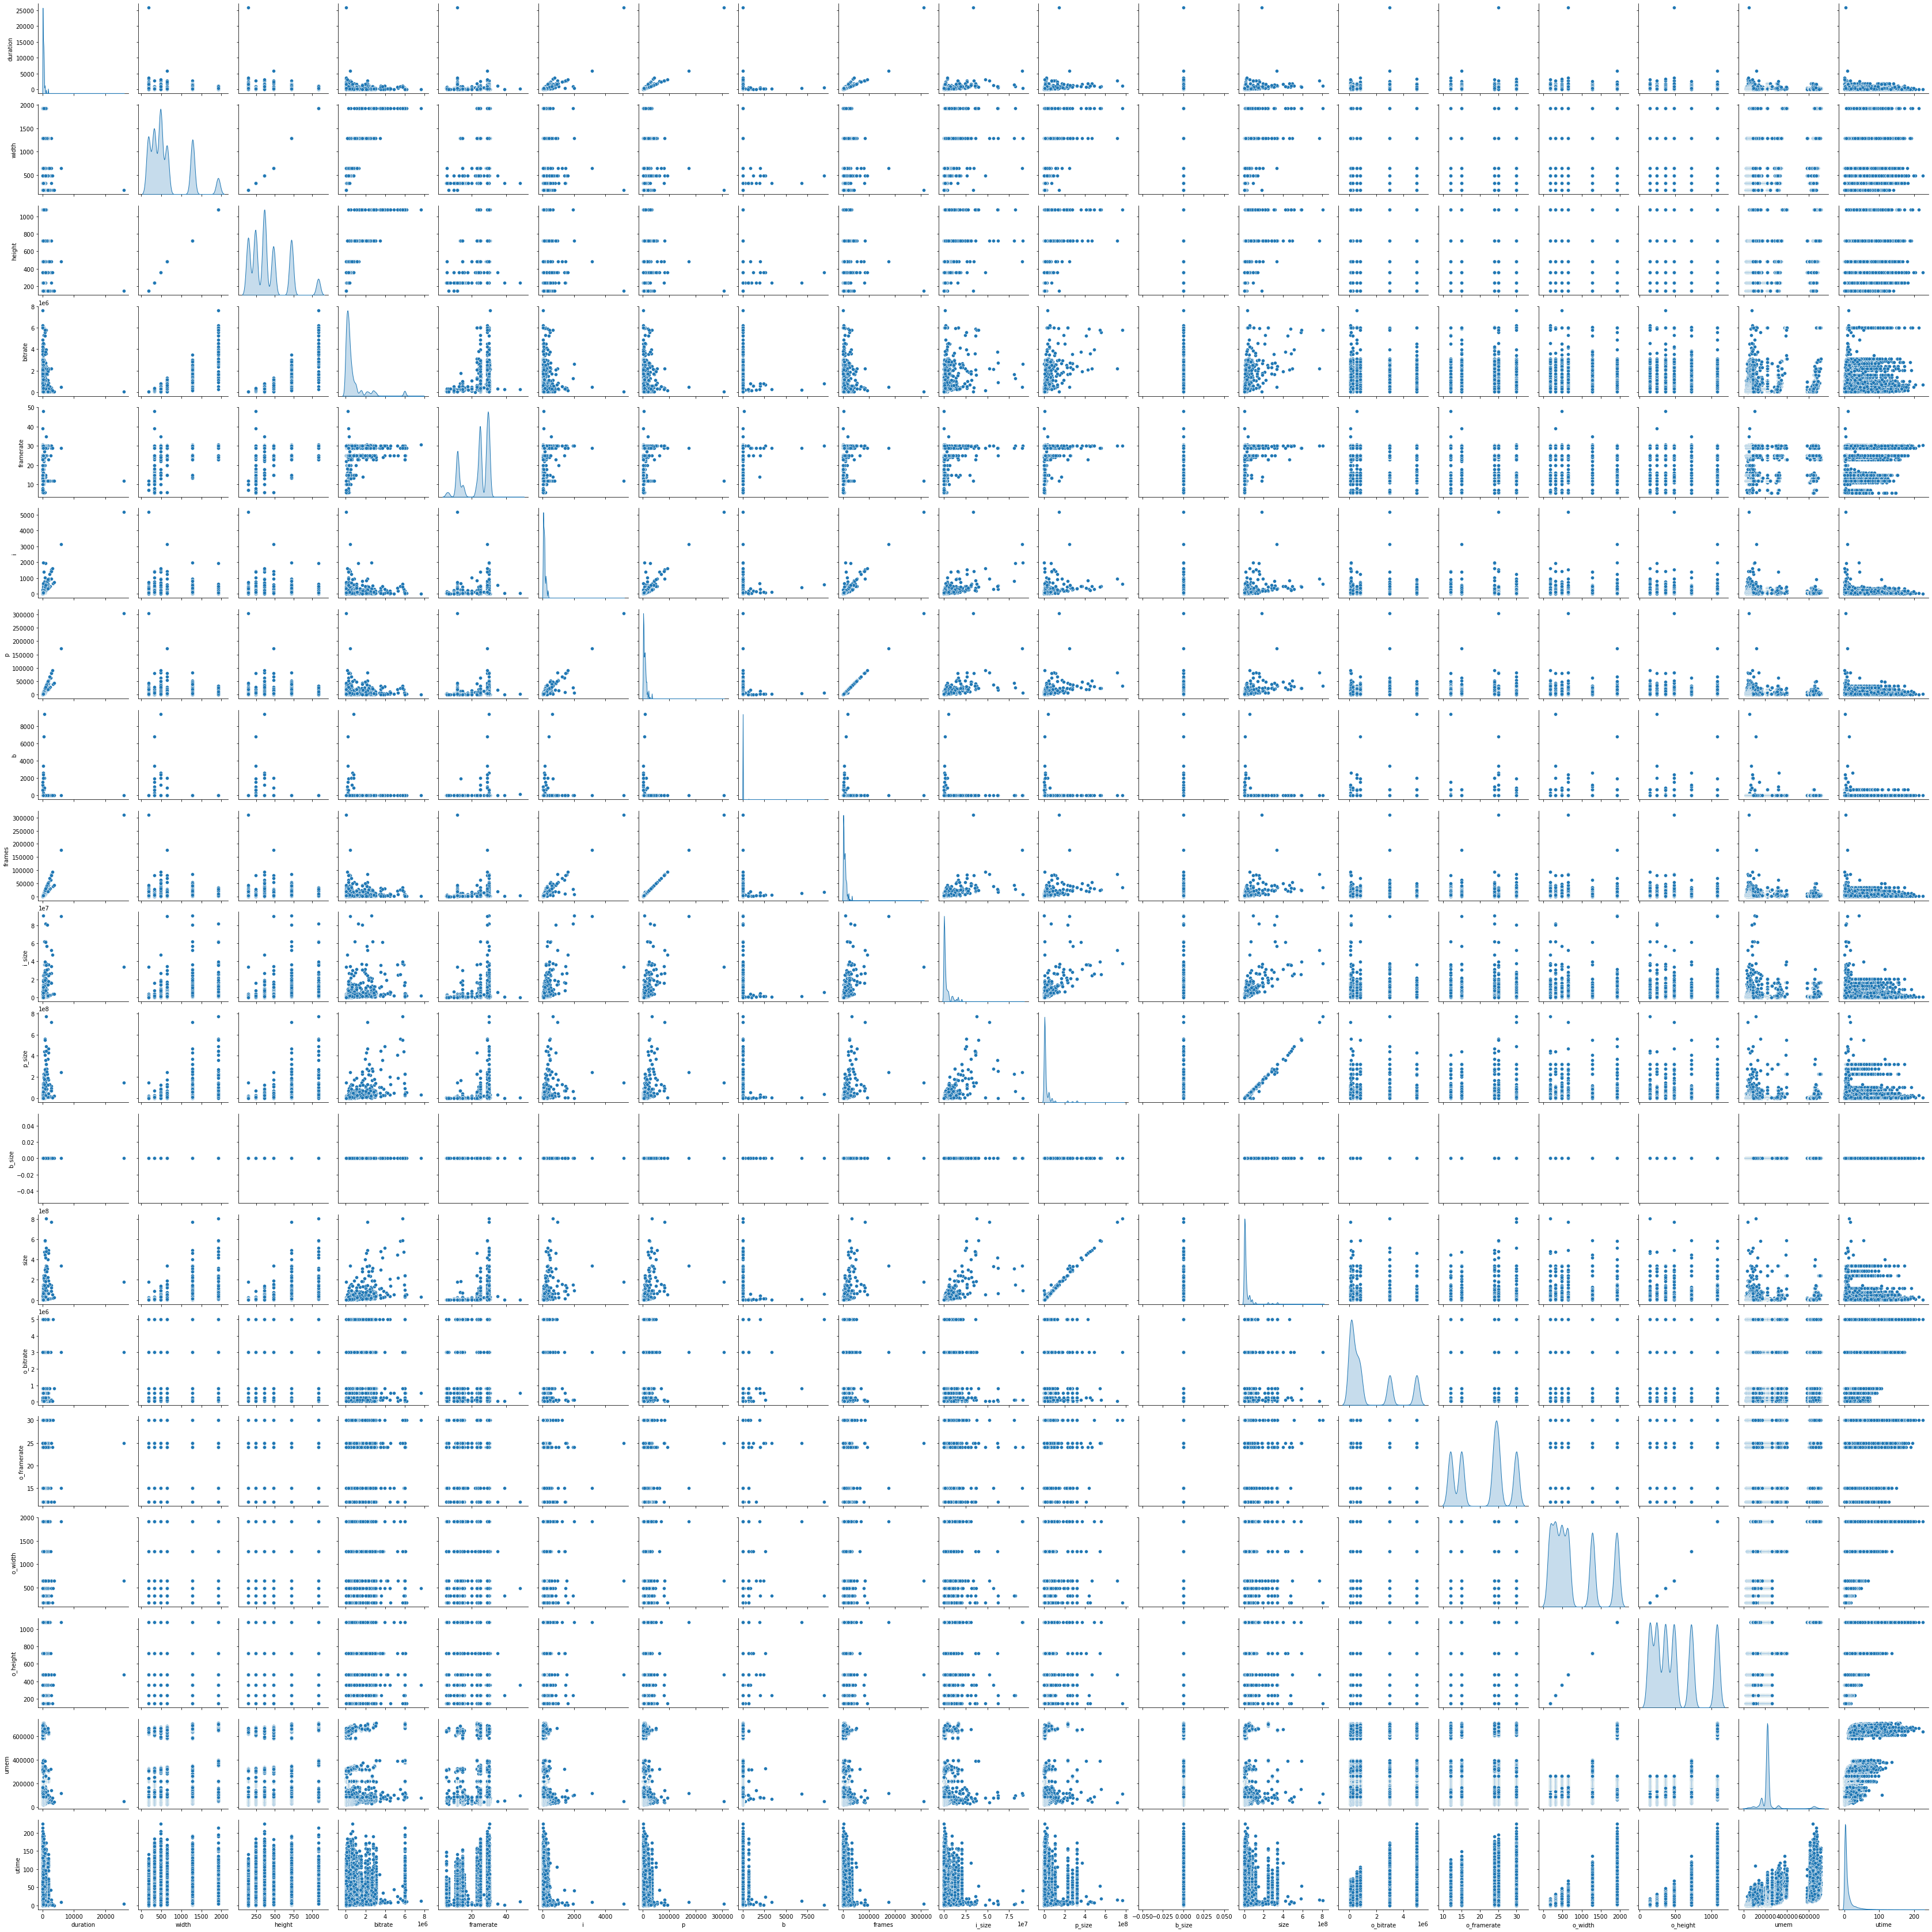

In [21]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sb

sb.pairplot(videos, diag_kind="kde")

### Data split into train and test batches with [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method

In [5]:
from sklearn.model_selection import train_test_split

videos_train_data, videos_test_data, \
videos_train_target, videos_test_target = \
train_test_split(scaled_video_data,video_target_time, test_size=0.25, random_state=1)

In [6]:
print("Training dataset:")
print("videos_train_data:", videos_train_data.shape)
print("videos_train_target:", videos_train_target.shape)

Training dataset:
videos_train_data: (51587, 20)
videos_train_target: (51587,)


In [7]:
print("Testing dataset:")
print("videos_test_data:", videos_test_data.shape)
print("videos_test_target:", videos_test_target.shape)

Testing dataset:
videos_test_data: (17196, 20)
videos_test_target: (17196,)


## Learning
### Training LinearRegression model and model evaluation 

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

linear_regression = LinearRegression()
linear_regression.fit(videos_train_data, videos_train_target)

print("Mean squared error of a learned model: %.2f" % 
      mean_squared_error(videos_test_target, linear_regression.predict(videos_test_data)))

print('Variance score: %.2f' % r2_score(videos_test_target, linear_regression.predict(videos_test_data)))

Mean squared error of a learned model: 90.96
Variance score: 0.65


###  Regression with Feed-Forward Neural Network (MLP) using MLPRegressor()

In [9]:
from sklearn.neural_network import MLPRegressor

neural_network = MLPRegressor(hidden_layer_sizes=(30,20,10,), activation='logistic', solver="sgd", \
                              batch_size=20, shuffle=True, momentum=0.95, alpha=1e-5, verbose=False, \
                              max_iter=500, tol=1e-7, random_state=1)

neural_network.fit(videos_train_data, videos_train_target)

print("Mean squared error of a learned model: %.2f" % 
      mean_squared_error(videos_test_target, neural_network.predict(videos_test_data)))

print('Variance score: %.2f' % r2_score(videos_test_target, neural_network.predict(videos_test_data)))


Mean squared error of a learned model: 16.79
Variance score: 0.94


### Model evaluation with [cross-validation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) (for linear regression)

In [10]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(LinearRegression(), scaled_video_data, video_target_time, cv=10)
print("Cross validation:")
[(round(score,2)) for score in scores]

Cross validation:


[0.44, 0.7, 0.66, 0.67, 0.64, 0.65, 0.63, 0.67, 0.47, -1.0107296694087877e+18]

## Prediction

In [17]:
id=8
linear_regression_prediction = linear_regression.predict(videos_test_data[id,:].reshape(1,-1))

#print(patients_test_data[id,:].shape)
#print(patients_test_data[id,:].reshape(1,-1).shape)

In [18]:
print("Model predicted for video {0} value {1}".format(id, linear_regression_prediction))

Model predicted for video 8 value [3.22520942]


In [19]:
print("Real value for video \"{0}\" is {1}".format(id, videos_test_target[id]))

Real value for video "8" is 3


In [20]:
# Kod programu w jednym bloku:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score


videos = pd.read_csv('transcoding_mesurment.tsv', sep='\t') 

data = videos.iloc[1:,1:-1] #dane
target = videos.iloc[1:,-1] #wynik

# Poniższa normalizacja została wykonana ze względu na ograniczenie:
# funkcja fit_transform przyjmuje argumenty jednego typu
# Użyliśmy metody hash dzięki której otrzymaliśmy 
# jednakową reprezntację dla każdego stringa przechowującego atrybut codec.

data["codec"] = [(hash(x)%10) for x in data["codec"]]
data["o_codec"] = [(hash(x)%10) for x in data["o_codec"]]


video_data = np.array(data, dtype=np.int64)
video_target_time = np.array(target, dtype=np.int64)

scaler = StandardScaler()
scaled_video_data = scaler.fit_transform(video_data)

videos_train_data, videos_test_data, \
videos_train_target, videos_test_target = \
train_test_split(scaled_video_data,video_target_time, \
    test_size=0.25, random_state=1)

print("================ LINEAR REGRESION:")
linear_regression = LinearRegression()
linear_regression.fit(videos_train_data, videos_train_target)

print('Variance score: %.2f' % \
    r2_score(videos_test_target, linear_regression.predict(videos_test_data)))

print("================ NEURAL NETWORK:")
neural_network = MLPRegressor(hidden_layer_sizes=(30,20,10,), \
    activation='logistic', \
    solver="sgd", \
    batch_size=20, \
    shuffle=True, \
    momentum=0.95, \
    alpha=1e-5, \
    verbose=False, \
    max_iter=500, \
    tol=1e-7, \
    random_state=1)

neural_network.fit(videos_train_data, videos_train_target)

print('Variance score: %.2f' % \
    r2_score(videos_test_target, neural_network.predict(videos_test_data)))

print("================ CROSS VALIDATION (LINEAR REGRESSION)")
scores = cross_val_score(LinearRegression(), \
             scaled_video_data, video_target_time, cv=10)
print("Cross validation:")
[(round(score,2)) for score in scores]

================ LINEAR REGRESION:
Variance score: 0.65
================ NEURAL NETWORK:
Variance score: 0.94
================ CROSS VALIDATION (LINEAR REGRESSION)
Cross validation:


[0.44, 0.7, 0.66, 0.67, 0.64, 0.65, 0.63, 0.67, 0.47, -1.0107296694087877e+18]